**IMPORTS**

In [10]:
!pip install sumy
!pip install sacrebleu
!pip install rouge

import re
import nltk
import json
import spacy
import numpy as np 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from time import time
from rouge import Rouge
from bs4 import BeautifulSoup
from collections import Counter
from sacrebleu.metrics import BLEU
from sumy.utils import get_stop_words
from sumy.nlp.stemmers import Stemmer
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer 
from sumy.summarizers.edmundson import EdmundsonSummarizer

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
print('The nltk version is {}.'.format(nltk.__version__)) # Verify version >3.5

nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The nltk version is 3.8.1.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**READING THE FOOD REVIEW DATASET**

In [2]:
fr_data = pd.read_csv("Reviews.csv",nrows=100000)

fr_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


****

In [7]:
fr_data.rename(columns={'Text': 'text', 'Summary': 'summary'}, inplace=True)

fr_data.drop_duplicates(subset=['text'], inplace=True)
fr_data.dropna(axis=0, inplace=True)

fr_data = fr_data[['summary', 'text']]

fr_data

,summary,text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
...,...,...
99995,yummy!,I just love it and will buy another box when I...
99996,Tastes like More!,My late father in law used to have a rating sy...
99997,Great ramen,This is my favorite brand of Korean ramen. It ...
99998,Spicy!!,"I do like these noodles although, to say they ..."


**PROCESSING THE DATASET**

In [16]:
def preprocess_text_for_extractive_models(data):
  """
  Performs data cleaning task to convert raw text data into a cleaned version 
  that contains only useful information.
  Input:
    data (list) - List of texts.
  """

  output = []
  for line in data:
    line = BeautifulSoup(line, "lxml").text
    line = line.lower() 
    output.append(line)
  return output


def preprocess(df):
  
  # News Article Cleaning
  text_clean = preprocess_text_for_extractive_models(df['text'].apply(str))
  # text_train = [str(doc) for doc in nlp.pipe(text_clean)]

  # News Summary Cleaning
  summary_clean = preprocess_text_for_extractive_models(df['summary'].apply(str))
  # summary_train = [str(doc) for doc in nlp.pipe(summary_clean)]

  final_text = []
  final_summary = []

  for i in range(len(text_clean)):
    final_text.append(text_clean[i])
    final_summary.append(summary_clean[i])

  return pd.DataFrame({'text': final_text, 'summary': final_summary})

reviews_df = preprocess(fr_data)

reviews_df

<ipython-input-16-74ffe8cc83a4>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  line = BeautifulSoup(line, "lxml").text
<ipython-input-16-74ffe8cc83a4>:11: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  line = BeautifulSoup(line, "lxml").text


,text,summary
0,i have bought several of the vitality canned d...,good quality dog food
1,product arrived labeled as jumbo salted peanut...,not as advertised
2,this is a confection that has been around a fe...,"""delight"" says it all"
3,if you are looking for the secret ingredient i...,cough medicine
4,great taffy at a great price. there was a wid...,great taffy
...,...,...
88416,i just love it and will buy another box when i...,yummy!
88417,my late father in law used to have a rating sy...,tastes like more!
88418,this is my favorite brand of korean ramen. it ...,great ramen
88419,"i do like these noodles although, to say they ...",spicy!!


In [17]:
def get_id_reviews_map(df):
  id_complete_review_map = {}
  id_summary_review_map = {}
  for id, review in enumerate(list(zip(df['text'], df['summary']))):
    complete_review, summary_review = review
    id_complete_review_map[id] = complete_review
    id_summary_review_map[id] = summary_review
  return id_complete_review_map, id_summary_review_map

id_complete_review_map, id_summary_review_map = get_id_reviews_map(reviews_df)

In [43]:
def get_bleu_score(hypothesis, reference):
  bleu_scorer = BLEU(effective_order=True)
  score = 0
  try:
    score = bleu_scorer.sentence_score(hypothesis=hypothesis, references=[reference])
  except:
    # print("hypothesis:", hypothesis)
    # print("reference:", reference)
    pass
  return score.score/100 if score else 0

def get_rouge_score(hypothesis, reference):
  rouge_scorer = Rouge()
  score = 0
  try:
    score = rouge_scorer.get_scores(hyps=hypothesis, refs=reference)
  except:
    pass
    # print("hypothesis:", hypothesis)
    # print("reference:", reference)
  return score[0]["rouge-l"]["f"] if score else 0

In [48]:
language = "english"
sentence_count = 1  # Denotes the number of sentences that should be in machine generated summary.

def summarize(summarizer, summarizer_name, id_complete_review_map, id_summary_review_map):
  summarizer_results = []
  for id in id_complete_review_map:
    text = id_complete_review_map[id]
    reference = id_summary_review_map[id]
    parser = PlaintextParser(text, Tokenizer(language))
    summary = summarizer(parser.document, sentence_count)
    hypothesis = " ".join(str(s) for s in summary)
    bleu_score = get_bleu_score(hypothesis, reference)
    rouge_score = get_rouge_score(hypothesis, reference)
    summarizer_results.append([id, text, reference, hypothesis, bleu_score, rouge_score])
    # print("============================================")
    # print("\033[1m Original Text (Cleaned): \033[0m\n", text
    # , "\n\033[1m Reference Summary (Cleaned): \033[0m\n", reference
    # , "\n\033[1m Candidate Summary: \033[0m\n", hypothesis
    # , "\n\033[1m BLEU Score: \033[0m", bleu_score
    # , "\n\033[1m ROUGE Score: \033[0m", rouge_score)
    # print("============================================")
  summarized_df = pd.DataFrame(summarizer_results, columns=["Document Id", "Original Text (Cleaned)", "Reference Summary (Cleaned)", "Candidate Summary (" + summarizer_name + ")", "BLEU Score", "ROUGE Score"])
  bleu_sorted = summarized_df.sort_values(by='BLEU Score', ascending=False)
  rouge_sorted = summarized_df.sort_values(by='ROUGE Score', ascending=False)
  return bleu_sorted, rouge_sorted

In [49]:
def print_sentences_in_new_line(text):
  s = ""
  for x in text.split("."):
    s += x + "\n"
  return s

def pretty_print(df, summarizer_name):
  for index, row in df:
    print("\033[1m Original Text (Cleaned): \033[0m\n", print_sentences_in_new_line(row['Original Text (Cleaned)'])
    , "\n\033[1m Reference Summary (Cleaned): \033[0m\n", print_sentences_in_new_line(row["Reference Summary (Cleaned)"])
    , "\n\033[1m Candidate Summary: \033[0m\n", print_sentences_in_new_line(row["Candidate Summary (" + summarizer_name + ")"])
    , "\n\033[1m BLEU Score: \033[0m", str(row["BLEU Score"])
    , "\n\033[1m ROUGE Score: \033[0m", str(row["ROUGE Score"]))
    print("\n\033[1m -------------------------------------------------------------- \033[0m\n")

In [50]:
lsa_summarizer = LsaSummarizer(Stemmer(language))
lsa_summarizer.stop_words = get_stop_words(language)

lsa_bleu_sorted, lsa_rouge_sorted = summarize(lsa_summarizer, "LSA", id_complete_review_map, id_summary_review_map)

print("\033[1m LSA Top 5 NEWS AND SUMMARIES - BLEU SCORES \033[0m")
pretty_print(lsa_bleu_sorted.head(5).iterrows(), "LSA")
print("\033[1m LSA Top 5 NEWS AND SUMMARIES - ROUGE SCORES \033[0m")
pretty_print(lsa_rouge_sorted.head(5).iterrows(), "LSA")

/usr/local/lib/python3.9/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (6) is lower than number of sentences (7). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/usr/local/lib/python3.9/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (1) is lower than number of sentences (5). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/usr/local/lib/python3.9/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (5) is lower than number of sentences (7). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/usr/local/lib/python3.9/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (3) is lower than number of sentences (4). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/usr/local/lib/python3.9/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (3) 

 LSA Top 5 NEWS AND SUMMARIES - BLEU SCORES 
 Original Text (Cleaned): 
 it's a shame to use so much corn syrup for babies! i'm very disappointed when i noticed that
 the same kind sold in china is even better

 
 Reference Summary (Cleaned): 
 it's a shame to use so much corn syrup for babies!
 
 Candidate Summary: 
 it's a shame to use so much corn syrup for babies!
 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 works well and doesn't sweat off
 i used this in roatan and mexico
 no death by vampire insects for me!
 
 Reference Summary (Cleaned): 
 works well and doesn't sweat off

 
 Candidate Summary: 
 works well and doesn't sweat off

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 i like this coffee
  that says it all! why should i go on when that is all to be sa

In [52]:
from sumy.summarizers.lex_rank import LexRankSummarizer 
lex_summarizer = LexRankSummarizer(Stemmer(language))
lex_summarizer.stop_words = get_stop_words(language)

lex_bleu_sorted, lex_rouge_sorted = summarize(lex_summarizer, "LexRank", id_complete_review_map, id_summary_review_map)

print("\033[1m LexRank Top 5 NEWS AND SUMMARIES - BLEU SCORES \033[0m")
pretty_print(lex_bleu_sorted.head(5).iterrows(), "LexRank")
print("\033[1m LexRank Top 5 NEWS AND SUMMARIES - ROUGE SCORES \033[0m")
pretty_print(lex_rouge_sorted.head(5).iterrows(), "LexRank")

 LexRank Top 5 NEWS AND SUMMARIES - BLEU SCORES 
 Original Text (Cleaned): 
 we love this coffee
 it is the best k cup we've found
 we like strong coffee and struggled at first to find one that we enjoyed
 the prices on amazon can't be beat and the shipping super fast

 
 Reference Summary (Cleaned): 
 we love this coffee

 
 Candidate Summary: 
 we love this coffee

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 ella's isn't half bad
 - glad to find these on sale at the warehouse deals
 ella's is one of the more pricer and smaller organic squeeze packs for kids so i only buy them on sale
 good for travel or fast playground snacks for toddlers

 
 Reference Summary (Cleaned): 
 ella's isn't half bad

 
 Candidate Summary: 
 ella's isn't half bad

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 O

In [53]:
from sumy.summarizers.luhn import LuhnSummarizer
luhn_summarizer = LuhnSummarizer(Stemmer(language))
luhn_summarizer.stop_words = get_stop_words(language)

luhn_bleu_sorted, luhn_rouge_sorted = summarize(luhn_summarizer, "Luhn", id_complete_review_map, id_summary_review_map)

print("\033[1m Luhn Top 5 NEWS AND SUMMARIES - BLEU SCORES \033[0m")
pretty_print(luhn_bleu_sorted.head(5).iterrows(), "Luhn")
print("\033[1m Luhn Top 5 NEWS AND SUMMARIES - ROUGE SCORES \033[0m")
pretty_print(luhn_rouge_sorted.head(5).iterrows(), "Luhn")

 Luhn Top 5 NEWS AND SUMMARIES - BLEU SCORES 
 Original Text (Cleaned): 
 loved this drink mix
  tasty, easy to use
  loved the lower calories
  plan to order this product, again
  thirst quenching

 
 Reference Summary (Cleaned): 
 loved this drink mix

 
 Candidate Summary: 
 loved this drink mix

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 love this stuff, dn't need cream/mik or sugar for my coffee, saves 100+ calories per cup!
 
 Reference Summary (Cleaned): 
 love this stuff, dn't need cream/mik or sugar for my coffee, saves 100+ calories per cup!
 
 Candidate Summary: 
 love this stuff, dn't need cream/mik or sugar for my coffee, saves 100+ calories per cup!
 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 who doesn't love terry's chocolate orange!  and cos it 

In [54]:
from sumy.summarizers.text_rank import TextRankSummarizer
text_rank_summarizer = TextRankSummarizer(Stemmer(language))
text_rank_summarizer.stop_words = get_stop_words(language)

text_rank_bleu_sorted, text_rank_rouge_sorted = summarize(text_rank_summarizer, "TextRank", id_complete_review_map, id_summary_review_map)

print("\033[1m TextRank Top 5 NEWS AND SUMMARIES - BLEU SCORES \033[0m")
pretty_print(text_rank_bleu_sorted.head(5).iterrows(), "TextRank")
print("\033[1m TextRank Top 5 NEWS AND SUMMARIES - ROUGE SCORES \033[0m")
pretty_print(text_rank_rouge_sorted.head(5).iterrows(), "TextRank")

 TextRank Top 5 NEWS AND SUMMARIES - BLEU SCORES 
 Original Text (Cleaned): 
 good product at a good price
 the texture is excellent
 cooks evenly
 living in the country far from a source of asian noodles this service is great
 now if they will start offering japanese spaghetti sauce 
 
 

 
 Reference Summary (Cleaned): 
 good product at a good price

 
 Candidate Summary: 
 good product at a good price

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 great product at a great price
  subscribe and save makes this an exceptional buy
  and oh yeah, my dogs love these too!
 
 Reference Summary (Cleaned): 
 great product at a great price

 
 Candidate Summary: 
 great product at a great price

 
 BLEU Score:  1.0000000000000004 
 ROUGE Score:  0.999999995

 -------------------------------------------------------------- 

 Original Text (Cleaned): 
 better than i expected for no-su

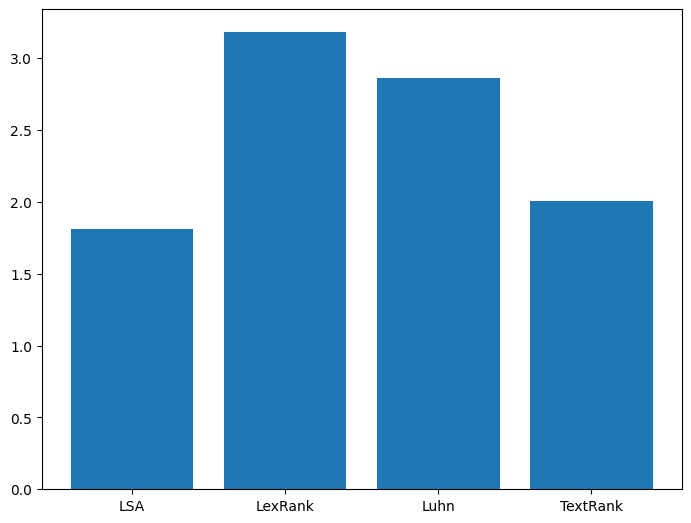

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
summarizers = ['LSA', 'LexRank', 'Luhn', 'TextRank']
BLEU_scores = [lsa_bleu_sorted['BLEU Score'].mean() * 100, 
               lex_bleu_sorted['BLEU Score'].mean() * 100, 
               luhn_bleu_sorted['BLEU Score'].mean() * 100,
               text_rank_bleu_sorted['BLEU Score'].mean() * 100]
ax.bar(summarizers, BLEU_scores)
plt.show()